In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import quaternion
from tqdm.notebook import tqdm

In [3]:
b, h, w = 1, 480, 640
i_range = torch.arange(0, h).view(1, h, 1).expand(1,h,w).float()  # [1, H, W]
j_range = torch.arange(0, w).view(1, 1, w).expand(1,h,w).float()  # [1, H, W]
ones = torch.ones(1,h,w).float()

pixel_coords = torch.stack((j_range, i_range, ones), dim=1)

In [25]:
def check_sizes(input, input_name, expected):
    condition = [input.ndimension() == len(expected)]
    for i,size in enumerate(expected):
        if size.isdigit():
            condition.append(input.size(i) == int(size))
    assert(all(condition)), "wrong size for {}, expected {}, got  {}".format(input_name, 'x'.join(expected), list(input.size()))

In [5]:
def pixel2cam(depth, intrinsics_inv):
    """
    Transform coordinates in the pixel frame to the camera frame.
    Args:
        depth: depth maps -- [B, H, W]
        intrinsics_inv: intrinsics_inv matrix for each element of batch -- [B, 3, 3]
    Returns:
        array of (u,v,1) cam coordinates -- [B, 3, H, W]
    """
    b, h, w = depth.size()
    current_pixel_coords = pixel_coords[:,:,:h,:w].expand(b,3,h,w).reshape(b, 3, -1)    # [B, 3, H*W]
    cam_coords = (intrinsics_inv @ current_pixel_coords).reshape(b, 3, h, w)            # [B, 3, H, W]

    return cam_coords * depth.unsqueeze(1)

In [6]:
def cam2pixel(cam_coords, proj_c2p_rot, proj_c2p_tr, padding_mode):
    """
    Transform coordinates in the camera frame to the pixel frame.
    Args:
        cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]    // tgt_depth * K_inv
        proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
        proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
    Returns:
        array of [-1,1] coordinates -- [B, 2, H, W]
    """
    b, _, h, w = cam_coords.size()
    cam_coords_flat = cam_coords.reshape(b, 3, -1)  # [B, 3, H*W]

    if proj_c2p_rot is not None:
        pcoords = proj_c2p_rot @ cam_coords_flat    # (K * P) * (D_tgt * K_inv)
    else:
        pcoords = cam_coords_flat

    if proj_c2p_tr is not None:
        pcoords = pcoords + proj_c2p_tr  # [B, 3, H*W]

    X = pcoords[:, 0]
    Y = pcoords[:, 1]
    Z = pcoords[:, 2].clamp(min=1e-3)

    X_norm = 2*(X / Z)/(w-1) - 1  # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
    Y_norm = 2*(Y / Z)/(h-1) - 1  # Idem [B, H*W]

    pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
    return pixel_coords.reshape(b,h,w,2)


In [7]:
def cam2homo(cam_coords, proj_c2p_rot, proj_c2p_tr, padding_mode='zeros'):
    """
    Transform coordinates in the camera frame to the pixel frame.
    Args:
        cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
        proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
        proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
    Returns:
        array of [-1,1] coordinates -- [B, 2, H, W]
    """
    b, _, h, w = cam_coords.size()
    cam_coords_flat = cam_coords.view(b, 3, -1)  # [B, 3, H*W]
    if proj_c2p_rot is not None:
        pcoords = proj_c2p_rot.bmm(cam_coords_flat)
    else:
        pcoords = cam_coords_flat

    if proj_c2p_tr is not None:
        pcoords = pcoords + proj_c2p_tr  # [B, 3, H*W]
    X = pcoords[:, 0]
    Y = pcoords[:, 1]
    Z = pcoords[:, 2].clamp(min=1e-3)

    X_homo = X / Z      # Homogeneous coords X
    Y_homo = Y / Z      # Homogeneous coords Y
    pixel_coords_homo = torch.stack([X_homo, Y_homo], dim=2)     # [B, H*W, 2]

    X_norm = 2*(X / Z)/(w-1) - 1  # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
    Y_norm = 2*(Y / Z)/(h-1) - 1  # Idem [B, H*W]
    if padding_mode == 'zeros':
        X_mask = ((X_norm > 1)+(X_norm < -1)).detach()
        X_norm[X_mask] = 2  # make sure that no point in warped image is a combination of im and gray
        Y_mask = ((Y_norm > 1)+(Y_norm < -1)).detach()
        Y_norm[Y_mask] = 2

    pixel_coords_norm = torch.stack([X_norm, Y_norm], dim=2)     # [B, H*W, 2]

    valid_points = pixel_coords_norm.view(b,h,w,2).abs().max(dim=-1)[0] <= 1
    valid_mask = valid_points.unsqueeze(1).float()

    return pixel_coords_homo.view(b,h,w,2), valid_mask

In [29]:
def depth2flow(depth, pose, intrinsics, reverse_pose=False, rotation_mode='euler', padding_mode='zeros'):
    """
    Depth + Pose => Flow
    Args:
        img: the source image (where to sample pixels) -- [B, 3, H, W]
        depth: depth map of the target image -- [B, 1, H, W]
        pose: 6DoF pose parameters from target to source -- [B, 6]
        intrinsics: camera intrinsic matrix -- [B, 3, 3]
    Returns:
        Source image warped to the target image plane
    """
    check_sizes(depth, 'depth', 'B1HW')
    check_sizes(pose, 'pose', 'B34')
    check_sizes(intrinsics, 'intrinsics', 'B33')

    batch_size, _, hh, ww = depth.size()    
    cam_coords = pixel2cam(depth.squeeze(1), intrinsics.inverse())  # D * K_inv * X, [B,3,H,W]
    pose_mat = pose

    if reverse_pose:
        aux_mat = torch.zeros([batch_size,4]).cuda().unsqueeze(1)
        aux_mat[:,:,3] = 1
        pose_mat = torch.cat([pose_mat, aux_mat], dim=1)    # [B, 4, 4]
        pose_mat = [t.inverse() for t in torch.functional.unbind(pose_mat)]
        pose_mat = torch.stack(pose_mat)                    # [B, 4, 4]
        pose_mat = pose_mat[:,:3,:]

    # Get projection matrix for tgt camera frame to source pixel frame
    proj_cam_to_src_pixel = intrinsics @ pose_mat                           # [B,3,4]
    rot, tr = proj_cam_to_src_pixel[:,:,:3], proj_cam_to_src_pixel[:,:,-1:]
    flow_grid, valid_mask = cam2homo(cam_coords, rot, tr, padding_mode)     # [B,H,W,2], [B,1,H,W]
    mgrid_np = np.expand_dims(np.mgrid[0:ww,0:hh].transpose(2,1,0).astype(np.float32),0).repeat(batch_size, axis=0)
    mgrid = torch.from_numpy(mgrid_np)                           # [B,H,W,2]
    
    flow_rigid = flow_grid - mgrid
    flow_rigid = flow_rigid.permute(0,3,1,2)

    return flow_rigid, valid_mask

In [72]:
TAG_FLOAT = 202021.25

TAG_CHAR = np.array([TAG_FLOAT], np.float32)

def flow_read(filename):
    """ Read optical flow from file, return (U,V) tuple. 
    
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    f = open(filename,'rb')
    check = np.fromfile(f,dtype=np.float32,count=1)[0]
    assert check == TAG_FLOAT, ' flow_read:: Wrong tag in flow file (should be: {0}, is: {1}). Big-endian machine? '.format(TAG_FLOAT,check)
    width = np.fromfile(f,dtype=np.int32,count=1)[0]
    height = np.fromfile(f,dtype=np.int32,count=1)[0]
    size = width*height
    assert width > 0 and height > 0 and size > 1 and size < 100000000, ' flow_read:: Wrong input size (width = {0}, height = {1}).'.format(width,height)
    tmp = np.fromfile(f,dtype=np.float32,count=-1).reshape((height,width*2))
    u = tmp[:,np.arange(width)*2]
    v = tmp[:,np.arange(width)*2 + 1]
    return u,v

def flow_write(filename,uv,v=None):
    """ Write optical flow to file.
    
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()

In [59]:
def flow2img(flow_data):
	"""
	convert optical flow into color image
	:param flow_data:
	:return: color image
	"""
	# print(flow_data.shape)
	# print(type(flow_data))
	u = flow_data[:, :, 0]
	v = flow_data[:, :, 1]

	UNKNOW_FLOW_THRESHOLD = 1e7
	pr1 = abs(u) > UNKNOW_FLOW_THRESHOLD
	pr2 = abs(v) > UNKNOW_FLOW_THRESHOLD
	idx_unknown = (pr1 | pr2)
	u[idx_unknown] = v[idx_unknown] = 0

	# get max value in each direction
	maxu = -999.
	maxv = -999.
	minu = 999.
	minv = 999.
	maxu = max(maxu, np.max(u))
	maxv = max(maxv, np.max(v))
	minu = min(minu, np.min(u))
	minv = min(minv, np.min(v))

	rad = np.sqrt(u ** 2 + v ** 2)
	maxrad = max(-1, np.max(rad))
	u = u / maxrad + np.finfo(float).eps
	v = v / maxrad + np.finfo(float).eps

	img = compute_color(u, v)

	idx = np.repeat(idx_unknown[:, :, np.newaxis], 3, axis=2)
	img[idx] = 0

	return np.uint8(img)


def compute_color(u, v):
	"""
	compute optical flow color map
	:param u: horizontal optical flow
	:param v: vertical optical flow
	:return:
	"""

	height, width = u.shape
	img = np.zeros((height, width, 3))

	NAN_idx = np.isnan(u) | np.isnan(v)
	u[NAN_idx] = v[NAN_idx] = 0

	colorwheel = make_color_wheel()
	ncols = np.size(colorwheel, 0)

	rad = np.sqrt(u ** 2 + v ** 2)

	a = np.arctan2(-v, -u) / np.pi

	fk = (a + 1) / 2 * (ncols - 1) + 1

	k0 = np.floor(fk).astype(int)

	k1 = k0 + 1
	k1[k1 == ncols + 1] = 1
	f = fk - k0

	for i in range(0, np.size(colorwheel, 1)):
		tmp = colorwheel[:, i]
		col0 = tmp[k0 - 1] / 255
		col1 = tmp[k1 - 1] / 255
		col = (1 - f) * col0 + f * col1

		idx = rad <= 1
		col[idx] = 1 - rad[idx] * (1 - col[idx])
		notidx = np.logical_not(idx)

		col[notidx] *= 0.75
		img[:, :, i] = np.uint8(np.floor(255 * col * (1 - NAN_idx)))

	return img


def make_color_wheel():
	"""
	Generate color wheel according Middlebury color code
	:return: Color wheel
	"""
	RY = 15
	YG = 6
	GC = 4
	CB = 11
	BM = 13
	MR = 6

	ncols = RY + YG + GC + CB + BM + MR

	colorwheel = np.zeros([ncols, 3])

	col = 0

	# RY
	colorwheel[0:RY, 0] = 255
	colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
	col += RY

	# YG
	colorwheel[col:col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / YG))
	colorwheel[col:col + YG, 1] = 255
	col += YG

	# GC
	colorwheel[col:col + GC, 1] = 255
	colorwheel[col:col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
	col += GC

	# CB
	colorwheel[col:col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / CB))
	colorwheel[col:col + CB, 2] = 255
	col += CB

	# BM
	colorwheel[col:col + BM, 2] = 255
	colorwheel[col:col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
	col += + BM

	# MR
	colorwheel[col:col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
	colorwheel[col:col + MR, 0] = 255

	return colorwheel

In [30]:
def get_color(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    color_path = os.path.join(folder, "0", f"{side}_rgb", str(frame_index) + ".jpg")
    color = cv2.imread(color_path, -1)

    if do_flip:
        color = np.fliplr(color)

    return color

def get_depth(folder, frame_index, side, do_flip):
    if side == 'r':
        side = 'right'
    else:
        side = 'left'

    depth_path = os.path.join(folder, "0", f"{side}_depth", str(frame_index) + ".png")
    depth = cv2.imread(depth_path, -1).astype(np.float32) * 10 / 65535

    if do_flip:
        depth = np.fliplr(depth)

    return depth

def get_pose(folder, frame_index, side, do_flip):
    # Refer to registration_test notebook.
    
    baseline = 0.2
    cam_height = 1.0
    
    cam_to_agent = np.eye(4)
    cam_to_agent[1,1] = -1  # Flip the y-axis of the point-cloud to be pointing upwards
    cam_to_agent[2,2] = -1  # Flip the z-axis of the point-cloud to follow right-handed coordinate system.
    
    if side == 'r':
        cam_to_agent[:3, 3] = np.array([baseline/2, cam_height, 0])
    else:
        cam_to_agent[:3, 3] = np.array([-baseline/2, cam_height, 0])

    pose_path = os.path.join(folder, "0", "pose", str(frame_index) + ".npy")
    agent_pose = np.load(pose_path, allow_pickle=True).item()

    R = np.eye(4)
    R[:3, :3] = quaternion.as_rotation_matrix(agent_pose['rotation'])

    T = np.eye(4)
    T[:3, 3] = agent_pose['position']
    
    M = (T @ R @ cam_to_agent).astype(np.float32)

    # The images will already be locally flipped. 
    # We need to only flip the camera's global x-coordinate.
    # Refer to registration_notebook.
    M[0,3] *= (1 - 2*do_flip)

    return M

def camera_intrinsic_transform(f_x, c_x, f_y, c_y):
    camera_intrinsics = np.zeros((3,4))
    camera_intrinsics[0][0] = f_x
    camera_intrinsics[1][1] = f_y
    camera_intrinsics[2][2] = 1
    camera_intrinsics[0][2] = c_x
    camera_intrinsics[1][2] = c_y
    
    return camera_intrinsics

In [31]:
root_dir = '/scratch/shantanu/HabitatGibson'

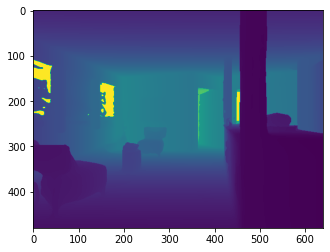

In [74]:
K = camera_intrinsic_transform(320, 320, 320, 240)[:3,:3]

scene = 'Allensville'

idx1 = 100
idx2 = 103

min_depth = 0.1
max_depth = 10.0

depth1 = get_depth(os.path.join(root_dir, 'data', scene), idx1, 'l', False)
depth1[depth1==0.0] = 10.0
depth1 = np.clip(depth1, min_depth, max_depth)

pose1 = get_pose(os.path.join(root_dir, 'data', scene), idx1, 'l', False)
pose2 = get_pose(os.path.join(root_dir, 'data', scene), idx2, 'l', False)
pose21 = (np.linalg.inv(pose2) @ pose1)[:3,:]

plt.imshow(depth1)

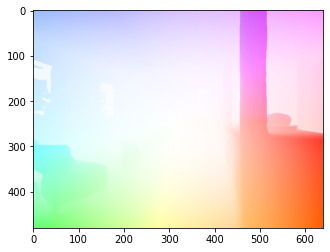

In [75]:
b_depth = torch.from_numpy(depth1).view(1,1,*depth1.shape).float()
b_pose = torch.from_numpy(pose21).view(1,*pose21.shape).float()
b_K = torch.from_numpy(K).view(1,*K.shape).float()

flow, mask = depth2flow(b_depth, b_pose, b_K)
flow = flow.squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

mask = mask.squeeze(0).squeeze(0).numpy().astype(np.uint8)

flow_img = flow2img(flow)
plt.imshow(flow_img)

In [76]:
def generate_flow(arg):
    root_dir, scene, idx1, idx2, out_dir = arg.split()
    
    frame_id = int(idx2) - int(idx1)
    
    K = camera_intrinsic_transform(320, 320, 320, 240)[:3,:3]
    min_depth = 0.1
    max_depth = 10.0

    depth1 = get_depth(os.path.join(root_dir, 'data', scene), idx1, 'l', False)
    depth1[depth1==0.0] = 10.0
    depth1 = np.clip(depth1, min_depth, max_depth)

    pose1 = get_pose(os.path.join(root_dir, 'data', scene), idx1, 'l', False)
    pose2 = get_pose(os.path.join(root_dir, 'data', scene), idx2, 'l', False)
    pose21 = (np.linalg.inv(pose2) @ pose1)[:3,:]
    
    b_depth = torch.from_numpy(depth1).view(1,1,*depth1.shape).float()
    b_pose = torch.from_numpy(pose21).view(1,*pose21.shape).float()
    b_K = torch.from_numpy(K).view(1,*K.shape).float()

    flow, mask = depth2flow(b_depth, b_pose, b_K)
    flow = flow.squeeze(0).squeeze(0).permute(1, 2, 0).numpy()

    mask = mask.squeeze(0).squeeze(0).numpy().astype(np.uint8)
    
    flow_save_path = os.path.join(out_dir, scene, '0', 'flow', f'f_{frame_id}', f'{idx1}.flo')
    os.makedirs(os.path.dirname(flow_save_path), exist_ok=True)
    flow_write(flow_save_path, flow)
    
    mask_save_path = os.path.join(out_dir, scene, '0', 'flow', f'm_{frame_id}', f'{idx1}.png')
    os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
    cv2.imwrite(mask_save_path, mask)

In [77]:
scenes = os.listdir(os.path.join(root_dir, 'data'))
frame_ids = [-3, -1, 1, 3]
out_dir = '/scratch/shantanu/HabitatGibson/flow'

generate_flow_args = []

for scene in scenes:
    filenames = sorted(os.listdir(os.path.join(root_dir, 'data', scene, '0', 'pose')), 
                       key=lambda x: int(os.path.splitext(x)[0]))


    for i in range(0, len(filenames), 2):
        filename = filenames[i]
        idx1 = int(os.path.splitext(filename)[0])

        for frame_id in frame_ids:
            idx2 = idx1 + frame_id

            if f'{idx2}.npy' not in filenames:
                continue

            generate_flow_args.append(f'{root_dir} {scene} {idx1} {idx2} {out_dir}')
        
print(len(generate_flow_args))
generate_flow_args[:2]

50956


['/scratch/shantanu/HabitatGibson Darden 0 1 /scratch/shantanu/HabitatGibson/flow',
 '/scratch/shantanu/HabitatGibson Darden 0 3 /scratch/shantanu/HabitatGibson/flow']

In [79]:
for arg in tqdm(generate_flow_args):
    generate_flow(arg)

  0%|          | 0/50956 [00:00<?, ?it/s]